In [1]:
import os
import glob
import sys
import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import torch as tr
import torch.nn as nn
import torch.optim as optim
from torch import distributions
from torch.nn.parameter import Parameter
print(sys.version)

3.12.3 (main, Apr  9 2024, 08:09:14) [Clang 15.0.0 (clang-1500.3.9.4)]


In [2]:
#O(3) generators
L  = tr.tensor([[[  0,  0,  0],
                 [  0,  0, -1],
                 [  0,  1,  0]],
                [[  0,  0,  1],
                 [  0,  0,  0],
                 [ -1,  0,  0]],
                [[  0, -1,  0],
                 [  1,  0,  0],
                 [ 0,  0,  0]]],dtype=tr.float)

In [3]:
v = tr.randn(3)
v = v/tr.norm(v)
u = tr.randn(3) 
u = u/tr.norm(u)

In [4]:
w = tr.linalg.cross(v,u,dim=0)

We can show that 
$$
(\vec v \times \vec u)_a = - v^T L^a u
$$

In [5]:
# computing the cross product using generators...
tr.einsum('s,sra,r->a',v,L,u) + tr.linalg.cross(v,u)

tensor([ 0.0000e+00, -3.7253e-09,  0.0000e+00])

In [6]:
# computing outer product with einsum
tr.einsum('s,r->sr',u,v) - tr.einsum('s,r->sr',v,u)  

tensor([[ 0.0000,  0.1189,  0.0553],
        [-0.1189,  0.0000, -0.7104],
        [-0.0553,  0.7104,  0.0000]])

In [7]:
#einsum contractions
tr.einsum('s,sra->ra',w,L)

tensor([[ 0.0000,  0.1189,  0.0553],
        [-0.1189,  0.0000, -0.7104],
        [-0.0553,  0.7104,  0.0000]])

In [8]:
#einsum for multi tensor contractions
tr.einsum('s,sra,r,kla->kl',v,L,u,L)

tensor([[ 0.0000, -0.1189, -0.0553],
        [ 0.1189,  0.0000,  0.7104],
        [ 0.0553, -0.7104,  0.0000]])

Rotating one vector to another.

$$
e^{\theta (n\cdot L)} = {\bf 1} + 2 \cos(\theta/2) \sin(\theta/2) (n\cdot L)  + 2 \sin^2(\theta/2) (n\cdot L)^2 ={\bf 1} +  \sin(\theta) (n\cdot L)  + (1-\cos(\theta)) (n\cdot L)^2
$$

If I want to rotate vector $\vec v$ to vector $\vec u$ where both are normalized then I need to perform the rotation

$$ 
R = e^{\theta\frac{\vec v \times \vec u}{|\vec v \times \vec u|}\cdot L }
$$

where $\theta$ is the angle between the two vectors.
$$
\cos(\theta) = \vec v \cdot \vec u
$$

$$
A = (\vec v \times \vec u) \cdot L = - \sum_a (v^T L^a u) L^a = u v^T - v u^T
$$
In our case  $\vec n = \frac{\vec v \times \vec u}{|\vec v \times \vec u|}$ and $\sin(\theta) = |\vec v \times \vec u|$ which leads to
$$ 
R = {\bf 1} +  A  + \frac{1-\cos(\theta)}{\sin^2(\theta)} A^2 = {\bf 1} +  A  + \frac{1}{ 1 + \cos(\theta)} A^2 = {\bf 1} +  A  + \frac{1}{ 1 + v^T u} A^2
$$
This formula has an apparent singularity for $\theta = \pi$ which might cause trouble.

In [17]:
def rotation(v,u):
    A = tr.einsum('s,r->sr',u,v) - tr.einsum('s,r->sr',v,u) 
    dd = tr.dot(u,v)
    return tr.eye(3) + A  + (A@A)/(1+dd)
    #return tr.eye(3) + A  + (A@A)*(1.0-dd)/(1-dd**2)

In [18]:
R= rotation(v,u)

In [19]:
R@v -u 

tensor([-2.9802e-08,  2.3842e-07,  0.0000e+00])

In [20]:
R.T@R

tensor([[ 1.0000e+00, -3.7857e-09,  6.5422e-08],
        [-3.7857e-09,  1.0000e+00,  4.0545e-08],
        [ 6.5422e-08,  4.0545e-08,  1.0000e+00]])

In [21]:
w = tr.randn(3)
w = w/tr.norm(w)

In [23]:
rotation(w,w)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [207]:
L=32
Bs=4
foo = tr.randn(Bs,3,3,L,L)
f = tr.randn(Bs,3,L,L)
nf = tr.norm(f,dim=1)
f=f/nf.view(Bs,1,L,L)

In [208]:
fooT = foo.transpose(1,2)

In [209]:
fooT[1,:,:,1,1], foo[1,:,:,1,1], fooT[1,:,:,1,1].T- foo[1,:,:,1,1]

(tensor([[-0.0702, -0.1419,  0.2844],
         [ 1.1830, -0.3889,  0.1729],
         [ 0.4689, -2.0186, -2.0850]]),
 tensor([[-0.0702,  1.1830,  0.4689],
         [-0.1419, -0.3889, -2.0186],
         [ 0.2844,  0.1729, -2.0850]]),
 tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]))

In [210]:
%timeit foo.transpose(1,2)

504 ns ± 2.33 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [211]:
%timeit tr.einsum('bsrxy->brsxy',foo)

2.3 µs ± 49.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [215]:
mask_c = [[0.25,0.25],[0.25,0.25]]
mask_r = [[1.00,1.00],[1.00,1.00]]
restrict = nn.Conv2d(groups=3,in_channels=3, out_channels=3, kernel_size=(2,2),stride=2,bias=False)
restrict.weight = tr.nn.Parameter(tr.tensor([[mask_c]]).repeat(3,1,1,1),requires_grad=False)
prolong = nn.ConvTranspose2d(groups=3,in_channels=3,out_channels=3,kernel_size=(2,2),stride=2,bias=False)
prolong.weight = tr.nn.Parameter(tr.tensor([[mask_r]]).repeat(3,1,1,1),requires_grad=False)
def coarsen(f):
    c = restrict(f)
    nc = tr.norm(c,dim=1)
    c = c/nc.view(c.shape[0],1,c.shape[2],c.shape[3])
    fc = prolong(c)
    #fc = fc/tr.norm(fc,dim=1).view(fc.shape[0],1,fc.shape[2],fc.shape[3])
    i_one_p_dot = 1.0/(1+tr.einsum('bsxy,bsxy->bxy',fc,f))
    A = tr.einsum('bsxy,brxy->bsrxy',fc,f) #- tr.einsum('bsxy,brxy->bsrxy',f,fc)
    A = A - A.transpose(1,2)
    A2 = tr.einsum('bxy,bskxy,bkrxy->bsrxy',i_one_p_dot,A,A)
    r = tr.eye(3,3).view(1,3,3,1,1) + A + A2
    return c,r,fc
def refine(c,r):
    f = prolong(c)
    # rotate with the transpose
    f = tr.einsum('brsxy,brxy->bsxy',r,f)
    #f = tr.einsum('bsrxy,brxy->bsxy',r,f)
    return f

In [216]:
%timeit c,r,fc=coarsen(f)

485 µs ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [218]:
%timeit ff=refine(c,r)

4.27 ms ± 31.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [219]:
c,r,fc=coarsen(f)
ff=refine(c,r)

In [234]:
tr.norm(f-ff).sum()/tr.norm(f),tr.norm(ff)

(tensor(3.1282e-07), tensor(64.))

In [221]:
f[1,:,1,1].norm()

tensor(1.0000)

In [222]:
c[1,:,1,1].norm()

tensor(1.)

In [223]:
r[1,:,:,1,1].T@r[1,:,:,1,1]

tensor([[ 1.0000e+00,  0.0000e+00, -5.9605e-08],
        [ 0.0000e+00,  1.0000e+00, -2.9802e-08],
        [-5.9605e-08, -2.9802e-08,  1.0000e+00]])

In [224]:
fc[1,:,1,1],tr.norm(fc[1,:,1,1])

(tensor([ 0.8547,  0.5164, -0.0520]), tensor(1.))

In [225]:
b0 = f[0,:,0:2,0:2]

In [226]:
c0 = b0.sum(dim=(1,2))
c0 = c0/tr.norm(c0)

In [227]:
c0

tensor([ 0.6182, -0.7573, -0.2106])

In [228]:
c[0,:,0,0]

tensor([ 0.6182, -0.7573, -0.2106])

In [229]:
c.shape

torch.Size([4, 3, 16, 16])

In [230]:
rn = tr.einsum('brkxy,bskxy->brsxy',r,r)

In [231]:
rn[0,:,:,0,0]

tensor([[ 1.0000e+00, -8.9000e-09, -8.2250e-08],
        [-8.9000e-09,  1.0000e+00, -2.0777e-08],
        [-8.2250e-08, -2.0777e-08,  1.0000e+00]])

In [233]:
tr.norm(rn - tr.eye(3).view(1,3,3,1,1))

tensor(5.1610e-05)

Using cpu device
Loading fields from:  o3_16_16_b1.263_bs4.pt
 HMC:  0  DH=  [0.0562744140625, -0.050537109375, -0.0548095703125, 0.01763916015625]  A/R=  [True, True, True, True]  Pacc=  1.0
 HMC:  1  DH=  [-0.0491943359375, 0.0400390625, 0.0537109375, 0.01959228515625]  A/R=  [True, True, True, True]  Pacc=  1.0
 HMC:  2  DH=  [0.0008544921875, -0.0216064453125, -0.05963134765625, 0.04278564453125]  A/R=  [True, True, True, True]  Pacc=  1.0
 HMC:  3  DH=  [-0.00640869140625, -0.00933837890625, 0.02398681640625, 0.012451171875]  A/R=  [True, True, True, True]  Pacc=  1.0
 HMC:  4  DH=  [0.040771484375, 0.0166015625, -0.00457763671875, -0.0452880859375]  A/R=  [True, True, True, True]  Pacc=  1.0
 HMC:  5  DH=  [-0.02197265625, 0.00775146484375, 0.01171875, 0.0181884765625]  A/R=  [True, True, True, True]  Pacc=  1.0
 HMC:  6  DH=  [-0.02960205078125, -0.015625, 0.08001708984375, -0.03594970703125]  A/R=  [True, True, True, True]  Pacc=  1.0
 HMC:  7  DH=  [0.0257568359375, -0.0323486

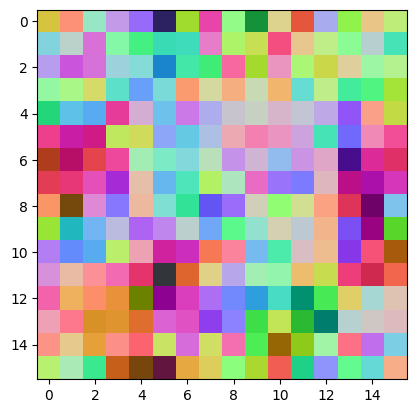

In [255]:
import time
import O3 as s
import update as u
import integrators as i
    
device = "cuda" if tr.cuda.is_available() else "cpu"
print(f"Using {device} device")

Nwarm =10
L=16
lat=[L,L]
V=L*L
batch_size=4
beta = 1.263
o  = s.O3(lat,beta,batch_size=batch_size)
    
sigma = o.hotStart()
file='no-load'
file='o3_16_16_b1.263_bs4.pt'
if(file != 'no-load'):
    print("Loading fields from: ",file)
    sigma=tr.load(file)
        
mn2 = i.minnorm2(o.force,o.evolveQ,7,1.0)
hmc = u.hmc(T=o,I=mn2)
sigma = hmc.evolve(sigma,Nwarm)
    
sig2img = (sigma[0].permute((1,2,0))+1.0)/2.0
print(sigma[0].shape,sig2img.shape)
plt.imshow(sig2img, interpolation='nearest')
tr.save(sigma,'o3_'+str(lat[0])+"_"+str(lat[1])+"_b"+str(beta)+"_bs"+str(o.Bs)+".pt")

In [266]:
c,r,fc=coarsen(sigma)
ff=refine(c,r)
print("Reversibility check: ",tr.norm(sigma-ff).sum()/tr.norm(sigma))
print("Orthogonality check: ",tr.norm(tr.einsum('brkxy,bskxy->brsxy',r,r) - tr.eye(3).view(1,3,3,1,1)))

Reversibility check:  tensor(2.2500e-06)
Orthogonality check:  tensor(6.8010e-05)


In [286]:
class RGlayer(nn.Module):
    def __init__(self,transformation_type="select",N=3):
        super(RGlayer, self).__init__()
        if(transformation_type=="select"):
            mask_c = [[1.0,0.0],[0.0,0.0]]
            mask_r = [[1.0,1.0],[1.0,1.0]]
        elif(transformation_type=="average"):
            mask_c = [[0.25,0.25],[0.25,0.25]]
            mask_r = [[1.00,1.00],[1.00,1.00]]
        else:
            print("Uknown RG blocking transformation. Using default.")
            mask_c = [[1.0,0.0],[0.0,0.0]]
            mask_r = [[1.0,0.0],[0.0,0.0]]
                  
        # We need this for debuging
        self.type = transformation_type
        print("Channels: ",N)
        self.restrict = nn.Conv2d(groups=N,in_channels=N, out_channels=N, kernel_size=(2,2),stride=2,bias=False)
        self.restrict.weight = tr.nn.Parameter(tr.tensor([[mask_c]]).repeat(N,1,1,1),requires_grad=False)
        self.prolong = nn.ConvTranspose2d(groups=N,in_channels=N,out_channels=N,kernel_size=(2,2),stride=2,bias=False)
        self.prolong.weight = tr.nn.Parameter(tr.tensor([[mask_r]]).repeat(N,1,1,1),requires_grad=False)

    def coarsen(self,f):
        c = self.restrict(f)
        c = c/tr.norm(c,dim=1).view(c.shape[0],1,c.shape[2],c.shape[3])
        fc = self.prolong(c)
        i_one_p_dot = 1.0/(1.0+tr.einsum('bsxy,bsxy->bxy',fc,f))
        A = tr.einsum('bsxy,brxy->bsrxy',fc,f)
        A = A - A.transpose(1,2)
        A2 = tr.einsum('bxy,bskxy,bkrxy->bsrxy',i_one_p_dot,A,A)
        r = tr.eye(3,3).view(1,3,3,1,1) + A + A2
        return c,r,fc
    
    def refine(self,c,r):
        # rotate with the transpose
        return tr.einsum('brsxy,brxy->bsxy',r,self.prolong(c))


In [287]:
rg = RGlayer(transformation_type="average")

Channels:  3


In [288]:
cc,rr,ffc=rg.coarsen(sigma)

In [289]:
ffc[0,:,1,0],fc[0,:,1,0]

(tensor([0.7091, 0.6556, 0.2595]), tensor([0.7091, 0.6556, 0.2595]))

In [290]:
cc[0,:,0,0],c[0,:,0,0]

(tensor([0.7091, 0.6556, 0.2595]), tensor([0.7091, 0.6556, 0.2595]))

In [291]:
rgS = RGlayer()

Channels:  3


In [292]:
ccS,rrS,ffcS=rgS.coarsen(sigma)

In [293]:
fsigmaS = rgS.refine(ccS,rrS)

In [294]:
tr.norm(fsigmaS - sigma)

tensor(0.0004)

In [296]:
fsigmaS[0,:,0,1],sigma[0,:,0,1]

(tensor([ 0.9877,  0.1438, -0.0619]), tensor([ 0.9877,  0.1438, -0.0619]))